In [22]:
%pip install pandas matplotlib scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz

In [2]:
N_STARLINK = 'Starlink'
N_SHAW = 'Home'
#src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']
#src_dirs = ['data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/', 'data/starlink-data/Ping/2022-06-06_starlink_ping/']
src_dirs = [('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/'), 
            ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/')]

#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [3]:
from common import combine_csvs
from common import region_mapping

In [5]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for region in os.scandir(folder):
        pattern = f"{region.path}/*"
        print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), 3, header=None)
        df_temp.index = pd.to_datetime(df_temp.index, unit='s')
        df_temp = df_temp.iloc[:,[2]]
        col_name = region_mapping[region.name]
        df_temp.rename(columns={df_temp.columns[0]: col_name}, inplace=True)
        df_temp.sort_index(inplace=True)
        
        # Add type multi column
        df_temp = pd.concat({type_name: df_temp}, axis=1)

        if not df.empty:
            df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
        else:
            df = df_temp

df

data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/South_America_Sao_Paulo/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Asia_Pacific_Singapore/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Asia_Pacific_Sydney/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Africa_Cape_Town/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/US_West_N_California/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Middle_East_Bahrain/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Asia_Pacific_Tokyo/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Europe_London/*
data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/Asia_Pacific_Mumbai/*
data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/South_America_Sao_Paulo/*
data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/Asia_Pacific_Singapore/*
data/starlink-data/Ping/2022-06-03_starlink_

Home                                           \
                    Sao Paulo Singapore Sydney Cape Town N. California   
3                                                                        
2022-06-03 09:22:05       NaN       NaN    NaN       NaN           NaN   
2022-06-03 09:22:06       NaN       NaN    NaN       NaN           NaN   
2022-06-03 09:22:07       NaN       NaN    NaN       NaN           NaN   
2022-06-03 09:22:08       NaN       NaN    NaN       NaN           NaN   
2022-06-03 09:22:09       NaN       NaN    NaN       NaN           NaN   
...                       ...       ...    ...       ...           ...   
2022-06-06 09:44:25       NaN       NaN    NaN       NaN           NaN   
2022-06-06 09:44:26       NaN       NaN    NaN       NaN           NaN   
2022-06-06 09:44:27       NaN       NaN    NaN       NaN           NaN   
2022-06-06 09:44:28       NaN       NaN    NaN       NaN           NaN   
2022-06-06 09:44:29       NaN       NaN    NaN       NaN           NaN   

                                                 Starlink                   \
                    Bahrain Tokyo London Mumbai Sao Paulo Singapore Sydney   
3                                                                            
2022-06-03 09:22:05     NaN   NaN    NaN    NaN       NaN       NaN  206.0   
2022-06-03 09:22:06     NaN   NaN    NaN    NaN       NaN       NaN  213.0   
2022-06-03 09:22:07     NaN   NaN    NaN    NaN       NaN       NaN  212.0   
2022-06-03 09:22:08     NaN   NaN    NaN    NaN       NaN       NaN  207.0   
2022-06-03 09:22:09     NaN   NaN    NaN    NaN       NaN       NaN  206.0   
...                     ...   ...    ...    ...       ...       ...    ...   
2022-06-06 09:44:25     NaN   NaN    NaN    NaN     213.0     194.0  218.0   
2022-06-06 09:44:26     NaN   NaN    NaN    NaN     221.0     202.0  225.0   
2022-06-06 09:44:27     NaN   NaN    NaN    NaN     211.0     191.0  214.0   
2022-06-06 09:44:28     NaN   NaN    NaN    NaN     202.0     178.0  216.0   
2022-06-06 09:44:29     NaN   NaN    NaN    NaN     206.0     189.0  215.0   

                                                                          
                    Cape Town N. California Bahrain  Tokyo London Mumbai  
3                                                                         
2022-06-03 09:22:05       NaN           NaN     NaN    NaN    NaN    NaN  
2022-06-03 09:22:06       NaN           NaN     NaN    NaN    NaN    NaN  
2022-06-03 09:22:07       NaN           NaN     NaN    NaN    NaN    NaN  
2022-06-03 09:22:08       NaN           NaN     NaN    NaN    NaN    NaN  
2022-06-03 09:22:09       NaN           NaN     NaN    NaN    NaN    NaN  
...                       ...           ...     ...    ...    ...    ...  
2022-06-06 09:44:25     319.0          49.9   242.0  127.0  163.0  295.0  
2022-06-06 09:44:26     318.0          48.8   241.0  142.0  162.0  294.0  
2022-06-06 09:44:27     310.0          48.5   241.0  130.0  158.0  283.0  
2022-06-06 09:44:28     317.0          46.9   243.0  137.0  161.0  285.0  
2022-06-06 09:44:29     316.0          45.8   238.0  128.0  156.0  284.0  

[542877 rows x 18 columns]

In [66]:
#df_temp = combine_csvs(glob.glob(f'{src_dirs[1]}/US_West_N_California/*', recursive=True), 3, header=None)
#df_temp.index = pd.to_datetime(df_temp.index, unit='s')
#df_temp.sort_index()
#df.loc['2022-06-17 01']

In [67]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [68]:
num_regs = int(len(df.columns) / 2) # One for each of Shaw vs Starlink
cols = df.columns.tolist()

new_cols = []
for col in cols:
    region = os.path.basename(col).replace('_',' ').strip()
    new_cols.append(region)

#new_cols = ['Sao Paulo', 'Singapore', 'Sydney', 'Cape Town'
#        'N. California', 'Bahrain', 'Tokyo', 'London']

multi_cols = [
        [N_SHAW] * num_regs + [N_STARLINK] * num_regs,
        new_cols
        ]
df.set_axis(multi_cols, axis=1, inplace=True)
df

Home                         \
                    South America Sao Paulo Asia Pacific Singapore   
3                                                                    
2022-06-03 09:22:05                     NaN                    NaN   
2022-06-03 09:22:06                     NaN                    NaN   
2022-06-03 09:22:07                     NaN                    NaN   
2022-06-03 09:22:08                     NaN                    NaN   
2022-06-03 09:22:09                     NaN                    NaN   
...                                     ...                    ...   
2022-06-06 09:44:25                     NaN                    NaN   
2022-06-06 09:44:26                     NaN                    NaN   
2022-06-06 09:44:27                     NaN                    NaN   
2022-06-06 09:44:28                     NaN                    NaN   
2022-06-06 09:44:29                     NaN                    NaN   

                                                                               \
                    Asia Pacific Sydney Africa Cape Town US West N California   
3                                                                               
2022-06-03 09:22:05                 NaN              NaN                  NaN   
2022-06-03 09:22:06                 NaN              NaN                  NaN   
2022-06-03 09:22:07                 NaN              NaN                  NaN   
2022-06-03 09:22:08                 NaN              NaN                  NaN   
2022-06-03 09:22:09                 NaN              NaN                  NaN   
...                                 ...              ...                  ...   
2022-06-06 09:44:25                 NaN              NaN                  NaN   
2022-06-06 09:44:26                 NaN              NaN                  NaN   
2022-06-06 09:44:27                 NaN              NaN                  NaN   
2022-06-06 09:44:28                 NaN              NaN                  NaN   
2022-06-06 09:44:29                 NaN              NaN                  NaN   

                                                                          \
                    Middle East Bahrain Asia Pacific Tokyo Europe London   
3                                                                          
2022-06-03 09:22:05                 NaN                NaN           NaN   
2022-06-03 09:22:06                 NaN                NaN           NaN   
2022-06-03 09:22:07                 NaN                NaN           NaN   
2022-06-03 09:22:08                 NaN                NaN           NaN   
2022-06-03 09:22:09                 NaN                NaN           NaN   
...                                 ...                ...           ...   
2022-06-06 09:44:25                 NaN                NaN           NaN   
2022-06-06 09:44:26                 NaN                NaN           NaN   
2022-06-06 09:44:27                 NaN                NaN           NaN   
2022-06-06 09:44:28                 NaN                NaN           NaN   
2022-06-06 09:44:29                 NaN                NaN           NaN   

                                                       Starlink  \
                    Asia Pacific Mumbai South America Sao Paulo   
3                                                                 
2022-06-03 09:22:05                 NaN                     NaN   
2022-06-03 09:22:06                 NaN                     NaN   
2022-06-03 09:22:07                 NaN                     NaN   
2022-06-03 09:22:08                 NaN                     NaN   
2022-06-03 09:22:09                 NaN                     NaN   
...                                 ...                     ...   
2022-06-06 09:44:25                 NaN                   213.0   
2022-06-06 09:44:26                 NaN                   221.0   
2022-06-06 09:44:27                 NaN                   211.0   
2022-06-06 09:44:28                 NaN               

In [69]:
test = df.dropna(how='all')
#test[test.isnull()]
#test['Home']['South America Sao Paulo']
test.isnull()

Home                         \
                    South America Sao Paulo Asia Pacific Singapore   
3                                                                    
2022-06-03 09:22:05                    True                   True   
2022-06-03 09:22:06                    True                   True   
2022-06-03 09:22:07                    True                   True   
2022-06-03 09:22:08                    True                   True   
2022-06-03 09:22:09                    True                   True   
...                                     ...                    ...   
2022-06-06 09:44:25                    True                   True   
2022-06-06 09:44:26                    True                   True   
2022-06-06 09:44:27                    True                   True   
2022-06-06 09:44:28                    True                   True   
2022-06-06 09:44:29                    True                   True   

                                                                               \
                    Asia Pacific Sydney Africa Cape Town US West N California   
3                                                                               
2022-06-03 09:22:05                True             True                 True   
2022-06-03 09:22:06                True             True                 True   
2022-06-03 09:22:07                True             True                 True   
2022-06-03 09:22:08                True             True                 True   
2022-06-03 09:22:09                True             True                 True   
...                                 ...              ...                  ...   
2022-06-06 09:44:25                True             True                 True   
2022-06-06 09:44:26                True             True                 True   
2022-06-06 09:44:27                True             True                 True   
2022-06-06 09:44:28                True             True                 True   
2022-06-06 09:44:29                True             True                 True   

                                                                          \
                    Middle East Bahrain Asia Pacific Tokyo Europe London   
3                                                                          
2022-06-03 09:22:05                True               True          True   
2022-06-03 09:22:06                True               True          True   
2022-06-03 09:22:07                True               True          True   
2022-06-03 09:22:08                True               True          True   
2022-06-03 09:22:09                True               True          True   
...                                 ...                ...           ...   
2022-06-06 09:44:25                True               True          True   
2022-06-06 09:44:26                True               True          True   
2022-06-06 09:44:27                True               True          True   
2022-06-06 09:44:28                True               True          True   
2022-06-06 09:44:29                True               True          True   

                                                       Starlink  \
                    Asia Pacific Mumbai South America Sao Paulo   
3                                                                 
2022-06-03 09:22:05                True                    True   
2022-06-03 09:22:06                True                    True   
2022-06-03 09:22:07                True                    True   
2022-06-03 09:22:08                True                    True   
2022-06-03 09:22:09                True                    True   
...                                 ...                     ...   
2022-06-06 09:44:25                True                   False   
2022-06-06 09:44:26                True                   False   
2022-06-06 09:44:27                True                   False   
2022-06-06 09:44:28                True               

In [79]:
# Filter
df_processed = df
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-05-10 08:29:00':'2022-05-10 8:33:00']
df_processed = df_processed.resample('H').mean()
#df_processed.to_csv('output/out.csv')
df_processed

Home                         \
                    South America Sao Paulo Asia Pacific Singapore   
3                                                                    
2022-06-03 09:00:00                     NaN                    NaN   
2022-06-03 10:00:00                     NaN                    NaN   
2022-06-03 11:00:00                     NaN                    NaN   
2022-06-03 12:00:00                     NaN                    NaN   
2022-06-03 13:00:00                     NaN                    NaN   
...                                     ...                    ...   
2022-06-06 05:00:00                     NaN                    NaN   
2022-06-06 06:00:00                     NaN                    NaN   
2022-06-06 07:00:00                     NaN                    NaN   
2022-06-06 08:00:00                     NaN                    NaN   
2022-06-06 09:00:00                     NaN                    NaN   

                                                                               \
                    Asia Pacific Sydney Africa Cape Town US West N California   
3                                                                               
2022-06-03 09:00:00                 NaN              NaN                  NaN   
2022-06-03 10:00:00                 NaN              NaN                  NaN   
2022-06-03 11:00:00                 NaN              NaN                  NaN   
2022-06-03 12:00:00                 NaN              NaN                  NaN   
2022-06-03 13:00:00                 NaN              NaN                  NaN   
...                                 ...              ...                  ...   
2022-06-06 05:00:00                 NaN              NaN                  NaN   
2022-06-06 06:00:00                 NaN              NaN                  NaN   
2022-06-06 07:00:00                 NaN              NaN                  NaN   
2022-06-06 08:00:00                 NaN              NaN                  NaN   
2022-06-06 09:00:00                 NaN              NaN                  NaN   

                                                                          \
                    Middle East Bahrain Asia Pacific Tokyo Europe London   
3                                                                          
2022-06-03 09:00:00                 NaN                NaN           NaN   
2022-06-03 10:00:00                 NaN                NaN           NaN   
2022-06-03 11:00:00                 NaN                NaN           NaN   
2022-06-03 12:00:00                 NaN                NaN           NaN   
2022-06-03 13:00:00                 NaN                NaN           NaN   
...                                 ...                ...           ...   
2022-06-06 05:00:00                 NaN                NaN           NaN   
2022-06-06 06:00:00                 NaN                NaN           NaN   
2022-06-06 07:00:00                 NaN                NaN           NaN   
2022-06-06 08:00:00                 NaN                NaN           NaN   
2022-06-06 09:00:00                 NaN                NaN           NaN   

                                                       Starlink  \
                    Asia Pacific Mumbai South America Sao Paulo   
3                                                                 
2022-06-03 09:00:00                 NaN              233.372061   
2022-06-03 10:00:00                 NaN              211.394592   
2022-06-03 11:00:00                 NaN              211.964197   
2022-06-03 12:00:00                 NaN              453.271452   
2022-06-03 13:00:00                 NaN              212.526606   
...                                 ...                     ...   
2022-06-06 05:00:00                 NaN              213.591556   
2022-06-06 06:00:00                 NaN              216.181266   
2022-06-06 07:00:00                 NaN              213.217140   
2022-06-06 08:00:00                 NaN              2

In [80]:
df_regs_interp = df_processed.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

Home                         \
                    South America Sao Paulo Asia Pacific Singapore   
3                                                                    
2022-06-03 09:00:00                     NaN                    NaN   
2022-06-03 10:00:00                     NaN                    NaN   
2022-06-03 11:00:00                     NaN                    NaN   
2022-06-03 12:00:00                     NaN                    NaN   
2022-06-03 13:00:00                     NaN                    NaN   
...                                     ...                    ...   
2022-06-06 05:00:00              191.577815             199.812951   
2022-06-06 06:00:00              191.608302             199.830238   
2022-06-06 07:00:00              191.638789             199.847525   
2022-06-06 08:00:00              191.669275             199.864812   
2022-06-06 09:00:00              191.699762             199.882099   

                                                                               \
                    Asia Pacific Sydney Africa Cape Town US West N California   
3                                                                               
2022-06-03 09:00:00                 NaN              NaN                  NaN   
2022-06-03 10:00:00                 NaN              NaN                  NaN   
2022-06-03 11:00:00                 NaN              NaN                  NaN   
2022-06-03 12:00:00                 NaN              NaN                  NaN   
2022-06-03 13:00:00                 NaN              NaN                  NaN   
...                                 ...              ...                  ...   
2022-06-06 05:00:00          152.238827       291.795120            34.813183   
2022-06-06 06:00:00          152.247719       291.825278            34.811737   
2022-06-06 07:00:00          152.256612       291.855436            34.810291   
2022-06-06 08:00:00          152.265504       291.885594            34.808845   
2022-06-06 09:00:00          152.274396       291.915752            34.807399   

                                                                          \
                    Middle East Bahrain Asia Pacific Tokyo Europe London   
3                                                                          
2022-06-03 09:00:00                 NaN                NaN           NaN   
2022-06-03 10:00:00                 NaN                NaN           NaN   
2022-06-03 11:00:00                 NaN                NaN           NaN   
2022-06-03 12:00:00                 NaN                NaN           NaN   
2022-06-03 13:00:00                 NaN                NaN           NaN   
...                                 ...                ...           ...   
2022-06-06 05:00:00          226.124102         143.910461    149.278678   
2022-06-06 06:00:00          226.058792         143.941210    149.287622   
2022-06-06 07:00:00          225.993481         143.971960    149.296566   
2022-06-06 08:00:00          225.928170         144.002709    149.305511   
2022-06-06 09:00:00          225.862859         144.033458    149.314455   

                                                       Starlink  \
                    Asia Pacific Mumbai South America Sao Paulo   
3                                                                 
2022-06-03 09:00:00                 NaN              241.975088   
2022-06-03 10:00:00                 NaN              241.544144   
2022-06-03 11:00:00                 NaN              241.113200   
2022-06-03 12:00:00                 NaN              240.682256   
2022-06-03 13:00:00                 NaN              240.251312   
...                                 ...                     ...   
2022-06-06 05:00:00          274.650303              220.914024   
2022-06-06 06:00:00          274.751269              220.790569   
2022-06-06 07:00:00          274.852235              220.667113   
2022-06-06 08:00:00          274.953201              2

In [81]:
df_unstacked = df_processed.unstack().reset_index(name='latency')
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
df_unstacked.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS, 3: N_TIMESTAMP},
        inplace=True)
df_unstacked.dropna(inplace=True)
df_unstacked.reset_index(drop=True, inplace=True)
#df_unstacked['hour'] = df_unstacked.timestamp.dt.to_period('H')
#df_unstacked = df_unstacked.set_index(['hour', N_TIMESTAMP])
#df_unstacked = df_unstacked.pivot_table(index='hour', columns=[N_TYPE, N_REGIONS, N_TIMESTAMP], values='latency')
df_unstacked

,Type,Regions,Timestamp,latency
0,Home,South America Sao Paulo,2022-06-04 03:00:00,218.305361
1,Home,South America Sao Paulo,2022-06-04 04:00:00,194.215369
2,Home,South America Sao Paulo,2022-06-04 05:00:00,190.501834
3,Home,South America Sao Paulo,2022-06-04 06:00:00,190.638332
4,Home,South America Sao Paulo,2022-06-04 07:00:00,234.550816
...,...,...,...,...
1075,Starlink,Asia Pacific Mumbai,2022-06-06 05:00:00,311.978491
1076,Starlink,Asia Pacific Mumbai,2022-06-06 06:00:00,291.123232
1077,Starlink,Asia Pacific Mumbai,2022-06-06 07:00:00,286.797798
1078,Starlink,Asia Pacific Mumbai,2022-06-06 08:00:00,283.569356


In [82]:
df_cdf = df_unstacked.groupby([N_TYPE, N_REGIONS])['latency'].apply(ecdf, False)
df_cdf

x         y
Type     Regions                                      
Home     Africa Cape Town     0   286.012208  0.021277
                              1   286.437074  0.042553
                              2   287.785695  0.063830
                              3   288.101180  0.085106
                              4   288.392044  0.106383
...                                      ...       ...
Starlink US West N California 68   75.362235  0.945205
                              69   86.399301  0.958904
                              70   89.135590  0.972603
                              71  102.222520  0.986301
                              72  117.289386  1.000000

[1080 rows x 2 columns]

In [ ]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

Text(0, 0.5, 'Latency (ms)')

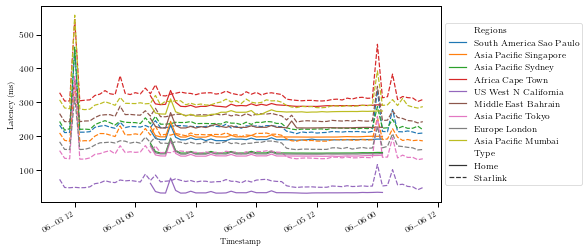

In [88]:
#fig, ax = plt.subplots(figsize=(3.5,2))
fig, ax = plt.subplots(figsize=(7.16,4))
#fig, ax = plt.subplots(figsize=(20,10))

g = sns.lineplot(data=df_unstacked, x=N_TIMESTAMP, y="latency", hue=N_REGIONS, style=N_TYPE, ax=ax)
g.figure.autofmt_xdate()
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Latency (ms)')

Text(0, 0.5, 'Proportion')

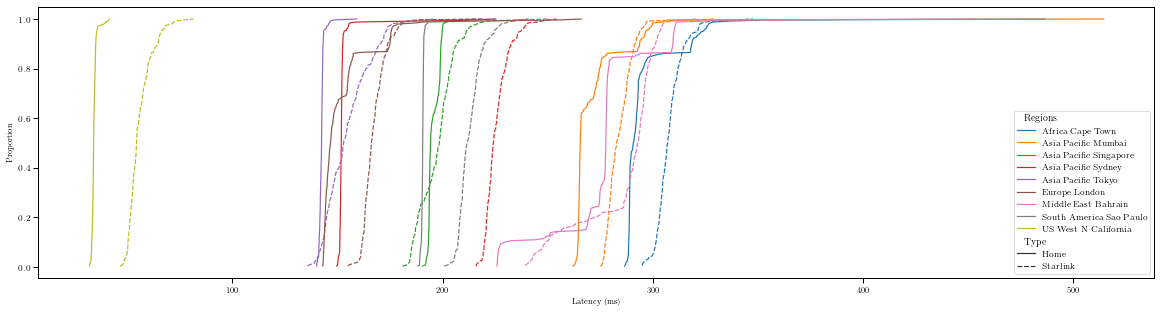

In [28]:
#fig, ax = plt.subplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
fig_cdf, ax_cdf = plt.subplots(figsize=(20,5))

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g = sns.lineplot(data=df_cdf, x='x', y="y", hue=N_REGIONS, style=N_TYPE, ax=ax_cdf)
#g.set(xscale='log')
ax_cdf.set_xlabel('Latency (ms)')
ax_cdf.set_ylabel('Proportion')

In [ ]:
fig

In [30]:
filename = 'output/Ping/out_plot'
fig.savefig(f'{filename}.pdf', bbox_inches='tight')
fig_cdf.savefig(f'{filename}_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')

In [ ]:
########
#fig, axs = plt.subplots(1, num_regs, figsize=(7.16,5))
#ax_big = fig.add_subplot(111, frameon=False)

#df_regions = []
#for i in range(num_regs):
#    df_region = df.iloc[:,[i,(num_regs+i)]]
#    boxplt = sns.boxplot(x="variable", y="value", data=pd.melt(df_region), ax=axs[i], showfliers=False)

#    raw_region = df_region.columns[0]
#    region = raw_region.split('/')[1].replace('_',' ').strip()
#    boxplt.set(xlabel=region, ylabel=None)

#    #axs[i].set(yscale='log')
#    axs[i].set_xticklabels(labels=["Shaw", "Starlink"], fontsize=9)
#    axs[i].tick_params(labelsize=9)


#ax_big.set_xlabel("Network Provider and Region", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_ylabel("Latency (ms)", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_yticklabels([])
#ax_big.set_xticklabels([])
#ax_big.tick_params(
#    which='both',
#    bottom=False,
#    left=False,
#    right=False,
#    top=False)
#ax_big.grid(False)
#############